In [1]:
from collections import namedtuple
from collections import OrderedDict
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.models import resnet50
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import VOCDetection
import torch.optim as optim
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import imageio
import math
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
import numpy as np
from easydict import EasyDict as edict
import tensorflow as tf
from IPython import display
import random
from torch.autograd.function import once_differentiable
from torch.autograd import Function
import math
import time

In [2]:
import matplotlib.font_manager as fm # to create font
fontsize = 24
FONT = ImageFont.truetype(fm.findfont(fm.FontProperties(family='DejaVu Sans')),fontsize)

In [3]:
def clip_to_image(boxes,size):
    
    boxes[:,0]=boxes[:,0].clamp(min=0,max=size[1]-1)
    boxes[:,1]=boxes[:,1].clamp(min=0,max=size[0]-1)
    boxes[:,2]=boxes[:,2].clamp(min=0,max=size[1]-1)
    boxes[:,3]=boxes[:,3].clamp(min=0,max=size[0]-1)
    
    keep=(boxes[:,2]>boxes[:,0])&(boxes[:,3]>boxes[:,1])
    
    boxes=boxes[keep]
    
    return boxes,keep
def remove_small_box(boxes,minsize):
    
    ws=boxes[:,2]-boxes[:,0]
    hs=boxes[:,3]-boxes[:,1]
    
    keep=(ws>=minsize)&(hs>=minsize)
    
    boxes=boxes[keep]
    
    return boxes,keep

In [4]:
resnet50=resnet50(pretrained=True)
resnet=nn.Sequential(*list(resnet50.children()))[:-2]


In [5]:
resnet.conv1=nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
resnet[4][0].downsample[0]=nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
resnet[4][0].conv2=nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [6]:
def _whctrs(anchors):
    w=anchors[2]-anchors[0]+1
    h=anchors[3]-anchors[1]+1
    ctr_x=anchors[0]+0.5*w
    ctr_y=anchors[1]+0.5*h
    
    return w,h,ctr_x,ctr_y

In [7]:
def _mkanchors(ws,hs,x_ctr,y_ctr):
    
    
    ws=ws.reshape(-1,1)
    hs=hs.reshape(-1,1)
    
    anchors=np.hstack((x_ctr-0.5*(ws-1),
                      y_ctr-0.5*(hs-1),
                      x_ctr+0.5*(ws-1),
                      y_ctr+0.5*(hs-1)))
    
    return anchors

In [8]:
def _ratio_enum(anchor,ratios):
    
    w,h,ctr_x,ctr_y=_whctrs(anchor)
    size=w*h
    
    size_ratios=size/ratios
    
    ws=np.round(np.sqrt(size_ratios))
    hs=np.round(ws*ratios)
    
    anchors=_mkanchors(ws,hs,ctr_x,ctr_y)
    
    return anchors
    

In [9]:
def _scale_enum(anchor,scales):
    
    w,h,x_ctr,y_ctr=_whctrs(anchor)
    ws=w*scales
    hs=h*scales
    anchors=_mkanchors(ws,hs,x_ctr,y_ctr)
    
    return anchors

In [10]:
def _generate_anchors(base_size,scales,aspect_ratios):
    
    anchor=torch.tensor([1,1,base_size,base_size])-1
    
    anchors=_ratio_enum(anchor,aspect_ratios)
    
    anchors=np.vstack(
    [_scale_enum(anchors[i,:],scales) for i in range(anchors.shape[0])])
    
    return torch.from_numpy(anchors)

In [11]:
def generate_anchors(stride=16,sizes=(32,64,128,256,512),aspect_ratios=(0.5,1,2)):
    
    return _generate_anchors(stride,
                            np.array(sizes,dtype=np.float64)/stride,#16
                            np.array(aspect_ratios,dtype=np.float64))

In [12]:
class AnchorGenerator(nn.Module):
    
    def __init__(self,sizes=(128,256,512),
                aspect_ratios=(0.5,1,2),
                anchor_strides=(8,16,32),
                straddle_thresh=0):
        super(AnchorGenerator,self).__init__()
        cell_anchor=[
            generate_anchors(anchor_stride,
                            size if isinstance(size, (tuple, list)) else (size,),
                            aspect_ratios).float()
            for anchor_stride,size in zip(anchor_strides,sizes)
        ]
        
        self.strides=anchor_strides
        self.straddle_thresh=straddle_thresh
        self.cell_anchor=cell_anchor
        
    def num_anchors_per_location(self):
        
            
        return [len(cell_anchors) for  cell_anchors in self.cell_anchor]
        
    def grid_anchors(self,grid_sizes):
        
        anchors=[]
        
        for size,stride,base_anchors in zip(grid_sizes,self.strides,self.cell_anchor):
            
            grid_height,grid_width=size
            
            device=base_anchors.device
            
            shift_x=torch.arange(0,grid_width*stride,step=stride,dtype=torch.float32,device=device)
            shift_y=torch.arange(0,grid_height*stride,step=stride,dtype=torch.float32,device=device)
            
            shift_y,shift_x=torch.meshgrid(shift_y,shift_x)
            shift_y=shift_y.reshape(-1)
            shift_x=shift_x.reshape(-1)
            
            shifts=torch.stack((shift_x,shift_y,shift_x,shift_y),dim=1)
            
            anchors.append(
                (shifts.view(-1,1,4)+base_anchors.view(1,-1,4)).reshape(-1,4)
            )
        return anchors
    
    
    
    #def add_visibility_to(self,boxlist):
        
    def forward(self,feature_maps):
        
        
        grid_sizes=[feature_map.shape[-2:] for feature_map in feature_maps]
        
        anchors_over_all_feature_maps=self.grid_anchors(grid_sizes)
        
        return anchors_over_all_feature_maps
       

In [13]:
def make_anchor_generator_retinaNet():
    
    anchor_sizes=(64,128,256,512,1024)
    aspect_ratios=(0.5,1.0,2.0)
    anchor_strides=(8,16,32,64,128)
    straddle_thresh=0
    octave=2.0
    scales_per_octave=3
    
    new_anchor_sizes=[]
    for size in anchor_sizes:
        
        per_layer_anchor_sizes=[]
        
        for scale_per_octave in range(scales_per_octave):
            
            octave_scale=octave**(scale_per_octave/float(scales_per_octave))
            per_layer_anchor_sizes.append(octave_scale*size)
        new_anchor_sizes.append(tuple(per_layer_anchor_sizes))
    
    anchor_generator=AnchorGenerator(tuple(new_anchor_sizes),aspect_ratios,anchor_strides,straddle_thresh)
    
    return anchor_generator
        
        

In [14]:
class Matcher(object):

    
    def __init__(self,high_threshold,low_threshold,allow_low_quality_matches=False):
        
        self.high_threshold=high_threshold
        self.low_threshold=low_threshold
        self.allow_low_quality_match=allow_low_quality_matches
    
    def __call__(self,match_quality_matrix,targets_labels):
        matched_vals,matches=match_quality_matrix.max(dim=0)
        
        labels=targets_labels[matches]+1
 
        if self.allow_low_quality_match:
            all_matches=matches.clone()
            all_labels=labels.clone()
        
        
        below_low_threshold=matched_vals<self.low_threshold
        
        between_thresholds=(matched_vals>=self.low_threshold)&(matched_vals<self.high_threshold)
        
        matches[below_low_threshold]=-1
        matches[between_thresholds]=-2
        labels[below_low_threshold]=-1
        labels[between_thresholds]=-2
        if self.allow_low_quality_match:
            
            matches,labels=self.set_low_quality_matches(matches,labels,all_matches,all_labels,match_quality_matrix)
        
        return matches,labels
    
    def set_low_quality_matches(self,matches,labels,all_matches,all_labels,match_quality_matrix):
        
        highest_quality_for_each_gt,_=match_quality_matrix.max(dim=1)
        
        gt_pred_pairs_of_highest_quality=torch.nonzero(
        match_quality_matrix==highest_quality_for_each_gt[:,None])
        
        pred_inds_to_update=gt_pred_pairs_of_highest_quality[:,1]
        
        matches[pred_inds_to_update]=all_matches[pred_inds_to_update]
        labels[pred_inds_to_update]=all_labels[pred_inds_to_update]
        return matches,labels

In [15]:
class BoxCoder(object):
    
    def __init__(self,weight,bbox_xform_clip=math.log(1000./16)):
        
        self.weight=weight
        self.bbox_xform_clip=bbox_xform_clip
        
    def encode(self,reference_box,proposals):
        wx, wy, ww, wh = self.weight

        ex_width=proposals[:,2]-proposals[:,0]+1
        ex_height=proposals[:,3]-proposals[:,1]+1
        ex_ctr_x=proposals[:,0]+0.5*ex_width
        ex_ctr_y=proposals[:,1]+0.5*ex_height
        
        gt_width=reference_box[:,2]-reference_box[:,0]+1
        gt_height=reference_box[:,3]-reference_box[:,1]+1
        gt_ctr_x=reference_box[:,0]+0.5*gt_width
        gt_ctr_y=reference_box[:,1]+0.5*gt_height
        
        
        target_dx=(gt_ctr_x-ex_ctr_x)/ex_width
        target_dy=(gt_ctr_y-ex_ctr_y)/ex_height
        target_dw=torch.log(gt_width/ex_width)
        target_dh=torch.log(gt_height/ex_height)
        
        targets=torch.stack((target_dx,target_dy,target_dw,target_dh),dim=1)
        
        return targets
    
    def decode(self,rel_codes,box):
        wx, wy, ww, wh = self.weight

        width=box[:,2]-box[:,0]+1
        height=box[:,3]-box[:,2]+1
        ctr_x=box[:,0]+0.5*width
        ctr_y=box[:,1]+0.5*height
        
        
        dx=rel_codes[:,0]
        dy=rel_codes[:,1]
        dw=rel_codes[:,2]
        dh=rel_codes[:,3]
        
        #dw=torch.clamp(dw,max=self.bbox_xform_clip)
        #dh=torch.clamp(dh,max=self.bbox_xform_clip)
        
        pred_ctr_x=dx[:,None]*width[:,None]+ctr_x[:,None]
        pred_ctr_y=dy[:,None]*height[:,None]+ctr_y[:,None]
        pred_w=torch.exp(dw[:,None])*width[:,None]
        pred_h=torch.exp(dh[:,None])*height[:,None]
        
        pred_boxes=torch.zeros_like(rel_codes)
        
        pred_boxes[:,0]=torch.squeeze(pred_ctr_x-0.5*pred_w)
        pred_boxes[:,1]=torch.squeeze(pred_ctr_y-0.5*pred_h)
        pred_boxes[:,2]=torch.squeeze(pred_ctr_x+0.5*pred_w-1)
        pred_boxes[:,3]=torch.squeeze(pred_ctr_y+0.5*pred_h-1)
        
        return pred_boxes

In [16]:
def boxlist_iou(boxlist1,boxlist2):
    
    N=len(boxlist1)
    M=len(boxlist2)
    
    area1=(boxlist1[:,2]-boxlist1[:,0]+1)*(boxlist1[:,3]-boxlist1[:,1]+1)
    
    area2=(boxlist2[:,2]-boxlist2[:,0]+1)*(boxlist2[:,3]-boxlist2[:,1]+1)
    
    lt=torch.max(boxlist1[:,None,:2],boxlist2[:,:2])
    rb=torch.min(boxlist1[:,None,2:],boxlist2[:,2:])
    
    hw=(rb-lt+1).clamp(min=0)
    
    inter=hw[:,:,0]*hw[:,:,1]
    
    iou=inter/(area1[:,None]+area2-inter)
    
    return iou

In [17]:
class RPNLossComputation(object):
    
    
    def __init__(self,proposal_matcher,fg_bg_sampler,box_coder,generate_labels_func):
        
        self.proposal_matcher=proposal_matcher
        self.fg_bg_sampler=fg_bg_sampler
        self.box_coder=box_coder
        self.copied_fields=[]
        self.generate_labels_func=generate_labels_func
        self.discard_cases=["not_visibility","between_thresholds"]
    
    
    def match_targets_to_anchors(self,anchors,targets,targets_labels):
        
        match_quality_matrix=boxlist_iou(targets,anchors)
        
        matched_idx,matched_labels=self.proposal_matcher(match_quality_matrix,targets_labels)
        
        matched_targets=targets[matched_idx.clamp(min=0)]
        
        return matched_idx,matched_targets,matched_labels
        
    def prepare_targets(self,anchors,targets,targets_labels):
        anchors=torch.cat(anchors,dim=0).to('cuda')
        index_out=torch.where((anchors[:,0]<0)| (anchors[:,1]<0)|(anchors[:,2]<0)|(anchors[:,3]<0))[0]
        labels=[]
        regression_targets=[]
        
        match_idx,matched_targets,matched_labels=self.match_targets_to_anchors(anchors,targets,targets_labels)

        #labels_per_image=self.generate_labels_func(match_idx)
        #labels_per_image=labels_per_image.to(dtype=torch.float32)

        bg_indices=match_idx==-1

        #labels_per_image[bg_indices]=0
        matched_labels[bg_indices]=0
        matched_labels[index_out]=0
        #if "not_visibility" in self.discard_cases:

        #    labels_per_image[out_bound]=-1#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #    matched_labels[out_bound]=0
       

        inds_to_discard=match_idx==-2

        #labels_per_image[inds_to_discard]=-1

        matched_labels[inds_to_discard]=0
        regression_targets_per_image=self.box_coder.encode(
        matched_targets,anchors)

        #labels.append(labels_per_image)

        regression_targets.append(regression_targets_per_image)

        return regression_targets[0],matched_labels
  
    def __call__(self,anchors,objectness,box_regression,targets):
        
        regression_targets,matched_labels=self.prepare_targets(anchors,targets,targets_labels)
        
        sampled_pos_inds,sampled_neg_inds=self.fg_bg_sampler(labels)
        
        sampled_pos_inds=torch.nonzero(torch.cat(sampled_pos_inds,dim=0)).squeeze(1)
        sampled_neg_inds=torch.nonzero(torch.cat(sampled_neg_inds,dim=0)).squeeze(1)
        
        sampled_inds=torch.cat([sampled_pos_inds,sampled_neg_inds],dim=0)
        matched_labels=matched_labels[sampled_inds]
        objectness,box_regression=concat_box_prediction_layers(objectness,box_regression)
        
        objectness=objectness.squeeze()
        
        labels=torch.cat(labels,dim=0)
        regression_targets=torch.cat(regression_targets,dim=0)
        
        box_loss=smooth_l1_loss(box_regression[sampled_pos_inds],
                               regression_targets[sampled_pos_inds],
                               )
        
        objectness_loss=F.binary_cross_entropy_with_logits(
        objectness[sampled_inds],labels[sampled_inds])
        
        return objectness_loss,box_loss

In [18]:
def sigmoid_focal_loss(logits,targets,gamma,alpha):
    num_classes=logits.shape[1]
    dtype=targets.dtype
    device=targets.device
    
    class_range=torch.arange(1,num_classes+1,dtype=dtype,device=device).unsqueeze(0)
    t=targets.unsqueeze(1)
    p=torch.sigmoid(logits)
    
    term1=(1-p)**gamma*torch.log(p)
    term2=p**gamma*torch.log(1-p)
    
    return -(t == class_range).float() * term1 * alpha - ((t != class_range) * (t >= 0)).float() * term2 * (1 - alpha)

In [19]:
class SigmoidFocalLoss(nn.Module):
    
    def __init__(self,gamma,alpha):
        super(SigmoidFocalLoss,self).__init__()
        
        self.gamma=gamma
        self.alpha=alpha
        
    def forward(self,logits,targets):
        
        device=logits.device
        
        loss=sigmoid_focal_loss(logits,targets,self.gamma,self.alpha)
        
        return loss.sum()

In [20]:
class RetinaNetLossComputation(RPNLossComputation):
    
    def  __init__(self,proposal_matcher,box_coder,sigmoid_focal_loss,bbox_reg_beta=0.11,regress_norm=1.0):
        
        self.proposal_matcher=proposal_matcher
        self.box_coder=box_coder
        self.box_cls_loss_func=sigmoid_focal_loss
        self.bbox_reg_beta=bbox_reg_beta
        self.regress_norm=regress_norm
    
    def __call__(self,anchors,box_cls,box_regression,targets,targets_labels):
        
        regression_targets,matched_labels=self.prepare_targets(anchors,targets,targets_labels)
        #sampled_pos_inds,sampled_neg_inds=balance_p_and_n_Sampler(256,0.5)(matched_labels)
        
        box_cls,box_regression=concat_box_prediction_layers(box_cls,box_regression)
        
        #sampled_pos_inds=torch.nonzero(torch.cat(sampled_pos_inds,dim=0)).squeeze(1)
        #sampled_neg_inds=torch.nonzero(torch.cat(sampled_neg_inds,dim=0)).squeeze(1)
        
        #sampled_inds=torch.cat([sampled_pos_inds,sampled_neg_inds],dim=0)
        pos_inds=torch.nonzero(matched_labels>0).squeeze(1)
        
        retinanet_regression_loss=smooth_l1_loss(box_regression[pos_inds],regression_targets[pos_inds])/\
        (max(1, pos_inds.numel() * self.regress_norm))
        
        matched_labels=matched_labels.int()
        
        retina_cls_loss=self.box_cls_loss_func(
        box_cls,
        matched_labels,
        )/(1+pos_inds.numel())
        
        
        return retina_cls_loss,retinanet_regression_loss
        
        

In [21]:
def make_retinanet_loss_evaluator(box_coder):
    
    matcher=Matcher(0.5,0.3,allow_low_quality_matches=True)
    sigmoid_focal_loss=SigmoidFocalLoss(2.0,0.25)
    loss_evaluator=RetinaNetLossComputation(
    matcher,
    box_coder,
    sigmoid_focal_loss,
    bbox_reg_beta=0.11,
    regress_norm=4.0)
    
    return loss_evaluator

In [22]:
class balance_p_and_n_Sampler(object):
    
    def __init__(self,batch_size_per_image,positive_fraction):
        
        self.batch_size_per_image=batch_size_per_image
        self.positive_fraction=positive_fraction
        
    def __call__(self,matched_idx):
        
       

        positive=torch.nonzero(matched_idx>=1).squeeze(1)
        negative=torch.nonzero(matched_idx<1).squeeze(1)

        num_pos=int(self.positive_fraction*self.batch_size_per_image)
        num_pos=min(positive.numel(),num_pos)

        num_neg=self.batch_size_per_image-num_pos

        num_neg=min(negative.numel(),num_neg)

        perm1=torch.randperm(positive.numel(),device=positive.device)[:,num_pos]
        perm2=torch.randperm(negative.numel(),device=negative.device)[:,num_neg]

        pos_idx_per_image=positive[perm1]
        neg_idx_per_image=negative[perm2]

        pos_idx_per_image_mask=torch.zeros_like(matched_idx,dtype=torch.uint8)
        neg_idx_per_image_mask=torch.zeros_like(matched_idx,dtype=torch.uint8)

        pos_idx_per_image_mask[pos_idx_per_image]=1
        neg_idx_per_image_mask[neg_idx_per_image]=1
            
            
        return pos_idx_per_image_mask,neg_idx_per_image_mask

In [23]:
def permute_and_flatten(layer, N, A, C, H, W):
    layer = layer.view(N, -1, C, H, W)
    layer = layer.permute(0, 3, 4, 1, 2)
    layer = layer.reshape(N, -1, C)
    return layer

In [24]:
def generate_rpn_labels(matched_idx):
    
    labels_per_image=matched_idx>0
    
    return labels_per_image

In [25]:
def concat_box_prediction_layers(box_cls,box_regression):
    
    box_cls_flattened=[]
    box_regression_flattened=[]
    
    for box_cls_level,box_regression_per_level in zip(box_cls,box_regression):
        
        N,G,H,W=box_cls_level.shape
        #G=A*C
        M=box_regression_per_level.shape[1]
        
        A=M//4
        
        C=G//A
        
        box_cls_level=permute_and_flatten(box_cls_level,N,A,C,H,W)[0]
        box_cls_flattened.append(box_cls_level)
        
        box_regression_per_level=permute_and_flatten(box_regression_per_level,N,A,4,H,W)[0]
        
        box_regression_flattened.append(box_regression_per_level)
        
    box_cls=torch.cat(box_cls_flattened,dim=0)
    box_regression=torch.cat(box_regression_flattened,dim=0)
    
    return box_cls,box_regression

In [26]:
def smooth_l1_loss(input,target,beta=1./9,size_average=False):
    
    n=torch.abs(input-target)
    cond=n<0.5
    loss=torch.where(cond,0.5*(n**2),n-0.5*beta)
    
    if size_average:
        return loss.mean()
    return loss.sum()

In [27]:
class RetinaNetHead(nn.Module):
    
    def __init__(self,in_channels):
        
        super(RetinaNetHead,self).__init__()
        
        num_class=20
        num_anchors=3*3
        
        cls_tower=[]
        bbox_tower=[]
        
        for i in range(4):
            
            cls_tower.append(
            nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=1,padding=1))
            cls_tower.append(nn.ReLU())
            bbox_tower.append(
            nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=1,padding=1))
            bbox_tower.append(nn.ReLU())
        self.add_module("cls_tower",nn.Sequential(*cls_tower))
        self.add_module("bbox_tower",nn.Sequential(*bbox_tower))
        
        self.cls_logits=nn.Conv2d(in_channels,num_anchors*num_class,kernel_size=3,stride=1,padding=1)
        self.bbox_pred=nn.Conv2d(in_channels,num_anchors*4,kernel_size=3,stride=1,padding=1)
        
        #for modules in [self.cls_tower,self.bbox_tower,self.cls_logits,self.bbox_pred]:
            
        #    for l in modules.modules():
                
        #        if isinstance(l,nn.Conv2d):
        #            nn.init.normal_(l.weight,std=0.01)
        #            nn.init.constant_(l.bias,0)
        
        #prior_prod=0.01
        #bias_value=-math.log((1-prior_prod)/prior_prod)
        #nn.init.constant_(self.cls_logits.bias,0)#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        
    def forward(self,x):
        
        logits=[]
        bbox_reg=[]
        for feature in x:
            
            logits.append(self.cls_logits(self.cls_tower(feature)))
            bbox_reg.append(self.bbox_pred(self.bbox_tower(feature)))
        
        return logits,bbox_reg
    

In [28]:
class RPNPostProcessor(nn.Module):
    
    def __init__(
    self,pre_nms_top_n,
    post_nms_top_n,
    nms_thresh,
    min_size,
    box_coder=None,
    fpn_post_nms_top_n=None):
        
        super(RPNPostProcessor,self).__init__()
        
        self.pre_nms_top_n=pre_nms_top_n
        seld.post_nms_top_n=post_nms_top_n
        self.nms_thresh=nms_thresh
        self.min_size=min_size
        
        if box_coder is None:
            box_coder=BoxCoder(weight=(1.0,1.0,1.0,1.0))
        self.box_coder=box_coder
        
        if fpn_post_nms_top_n is None:
            self.fpn_post_nms_top_n=post_nms_top_n
            
        self.fpn_post_nms_top_n=fpn_post_nms_top_n
        
        
    
        

In [29]:
class RetinaNetPostProcessor(nn.Module):
    
    def __init__(self,
                pre_nms_thresh,
                pre_nms_top_n,
                nms_thresh,
                fpn_post_nms_top_n,
                min_size,
                num_classes,
                box_coder=None):
        
        super(RetinaNetPostProcessor,self).__init__()
        self.pre_nms_thresh=pre_nms_thresh
        self.pre_nms_top_n=pre_nms_top_n
        self.nms_thresh=nms_thresh
        self.fpn_post_nms_top_n=fpn_post_nms_top_n
        self.min_size=min_size
        self.num_classes=num_classes
        if box_coder is None:
            box_coder=BoxCoder(weight=(10., 10., 5., 5.))
        self.box_coder=box_coder
        
    def forward_for_single_feature_map(self,anchors,box_cls,box_regression,image_sizes):
        device=box_cls.device
        N,_,H,W=box_cls.shape
       
        A=box_regression.size(1)//4
        C=box_cls.size(1)//A
        
        box_cls=permute_and_flatten(box_cls,N,A,C,H,W)
        box_cls=box_cls.sigmoid()
        box_regression=permute_and_flatten(box_regression,N,A,4,H,W)
        box_regression=box_regression.reshape(N,-1,4)
        
        num_anchors=A*W*H
        self.pre_nms_thresh=0
        candidate_inds=box_cls>=self.pre_nms_thresh
        pre_nms_top_n=candidate_inds.reshape(N,-1).sum(1)
        pre_nms_top_n=pre_nms_top_n.clamp(max=self.pre_nms_top_n)
        
        results=[]
        
        per_box_cls=box_cls[0]
        per_box_regression=box_regression[0]
        per_pre_nms_top_n=pre_nms_top_n[0]
        per_canidate_inds=candidate_inds[0]
        per_anchors=anchors.to('cuda')
        
        per_box_cls=per_box_cls[per_canidate_inds]
        per_box_cls,top_k_indices=per_box_cls.topk(pre_nms_top_n.item(),sorted=False)
        per_canidate_nonzeros=per_canidate_inds.nonzero()[top_k_indices,:]
        
        per_box_cls=per_canidate_nonzeros[:,0]
        per_class=per_canidate_nonzeros[:,1]
        
        
        detections=self.box_coder.decode(
        per_box_regression[per_box_cls,:],
        per_anchors[per_box_cls,:])
        
        h,w=image_sizes[0]
        size=[h,w]
       
        detections,keeps=clip_to_image(detections,size)
        labels=per_class[keeps]
        scores=per_box_cls[keeps]

        detections,keeps=remove_small_box(detections,self.min_size)
        labels=labels[keeps]
        scores=scores[keeps]
        out={
                "detections":detections,
                "labels":labels,
                "scores":scores
            }
        return out
    def select_over_all_levels(self,boxes,labels,scores):
        results_boxes=[]
        results_labels=[]
        results_scores=[]
        for j in range(1,self.num_classes):
            
            inds=(labels==j).nonzero().reshape(-1)
            if len(inds)==0:
                continue
            labels_j=labels[inds]
            scores_j=scores[inds]
            boxes_j=boxes[inds,:].reshape(-1,4)
            
          #  keep=self.nms(boxes_j,scores_j,Threshold=self.nms_thresh)
            
          #  boxes_j=boxes_j[keep]
          #  labels_j=labels_j[keep]
          #  scores_j=scores_j[keep]
            results_boxes.append(boxes_j)
            results_labels.append(labels_j)
            results_scores.append(scores_j)
        
        boxes=torch.vstack(results_boxes)
        labels=torch.hstack(results_labels)
        scores=torch.hstack(results_scores)
        
        
        return boxes,labels,scores
    
    
    
    def forward(self,anchors,box_cls,box_regression,image_sizes):
        
        sampled_boxes=[]
        for _,(l,o,b)in enumerate(zip(anchors,box_cls,box_regression)):
            
            sampled_boxes.append(self.forward_for_single_feature_map(l,o,b,image_sizes))
            
        boxes=torch.vstack((sampled_boxes[0]["detections"],sampled_boxes[1]["detections"],sampled_boxes[2]["detections"]
                           ,sampled_boxes[3]["detections"],sampled_boxes[4]["detections"]))
        labels=torch.hstack((sampled_boxes[0]["labels"],sampled_boxes[1]["labels"],sampled_boxes[2]["labels"]
                           ,sampled_boxes[3]["labels"],sampled_boxes[4]["labels"]))
        
        scores=torch.hstack((sampled_boxes[0]["scores"],sampled_boxes[1]["scores"],sampled_boxes[2]["scores"]
                           ,sampled_boxes[3]["scores"],sampled_boxes[4]["scores"]))
        
        boxes,labels,scores=self.select_over_all_levels(boxes,labels,scores)
        
        number_of_detections=len(boxes)
        
        if number_of_detections >self.fpn_post_nms_top_n>0:
            
            thresh,_=torch.kthvalue(scores,number_of_detections-self.fpn_post_nms_top_n+1)
            
            keep=scores>=thresh
            
            keep=torch.nonzero(keep).squeeze(1)
            
            boxes=boxes[keep,:]
            labels=labels[keep]
            
            scores=scores[keep]
        return boxes,labels,scores
            
            
            
            
        

In [30]:
def make_retinanet_postprocessor(box_coder):
    
    pre_nms_thresh=0.05
    pre_nms_top_n=1000
    nms_thresh=0.4
    fpn_post_nms_top_n=100
    min_size=15
    
    box_selector=RetinaNetPostProcessor(
    pre_nms_thresh=pre_nms_thresh,
    pre_nms_top_n=pre_nms_top_n,
    nms_thresh=nms_thresh,
    fpn_post_nms_top_n=fpn_post_nms_top_n,
    min_size=min_size,
    num_classes=21,
    box_coder=box_coder)
    
    return box_selector

In [31]:
class RetinaNetModule(nn.Module):
    
    def __init__(self,in_channels):
        
        super(RetinaNetModule,self).__init__()
        
        anchor_generator=make_anchor_generator_retinaNet()
        
        head=RetinaNetHead(in_channels)
        
        box_coder=BoxCoder(weight=(10., 10., 5., 5.))
        loss_evaluator=make_retinanet_loss_evaluator(box_coder)
        box_selector_test=make_retinanet_postprocessor(box_coder)
        
        self.anchor_generator=anchor_generator
        self.head=head
        self.loss_evaluator=loss_evaluator
        self.box_selector_test=box_selector_test
    def _forward_train(self,anchors,box_cls,box_regression,targets,targets_labels):
        
        retina_cls_loss,retinanet_regression_loss=self.loss_evaluator(anchors,box_cls,box_regression,targets,targets_labels)
        
        return retina_cls_loss+retinanet_regression_loss
    
    def _forward_test(self,anchors,box_cls,box_regression,image_sizes):
        
        boxes,labels,scores=self.box_selector_test(anchors,box_cls,box_regression,image_sizes)
        
        out=[boxes,labels,scores]
        
        return out
            
            
    def forward(self,features,targets=None,targets_labels=None,is_training=False,image_sizes=None):
        
        box_cls,box_regression=self.head(features)

        anchors=self.anchor_generator(features)
        if is_training:
            
            return self._forward_train(anchors,box_cls,box_regression,targets,targets_labels)
        else:
            
            return self._forward_test(anchors,box_cls,box_regression,image_sizes)
        

In [32]:
class make_layers(nn.Module):
    def __init__(self):
        super(make_layers,self).__init__()
        
    
    def get_group_gn(self,dim,dim_per_gp,num_group):
        
        if dim_per_gp>0:
            
            group_gn=dim//dim_per_gp
        else:
            
            group_gn=num_group
        return group_gn
    
    def group_norm(self,out_channel,affine=True,divisor=1):
        
        out_channel=out_channel//divisor
        
        dim_per_gp=-1//divisor
        
        num_group=32//divisor
        
        eps=1e-5
        
        return nn.GroupNorm(self.get_group_gn(out_channel,dim_per_gp,num_group),
                           out_channel,
                           eps,
                           affine)
    
    def conv_with_kaiming_uniform(self,in_channel,out_channel,kernel_size,use_gn=False,use_relu=False,stride=1,dilation=1):
        
        conv=nn.Conv2d(in_channel,out_channel,kernel_size,stride,padding=dilation*(kernel_size-1)//2,bias=False if use_gn else True)

        nn.init.kaiming_normal_(conv.weight,a=1)

        if not use_gn:

            nn.init.constant_(conv.bias,0)

        module=[conv,]

        if use_gn:

            module.append(self.group_norm(out_channel))
        if use_relu:

            module.append(nn.ReLU(inplace=True))

        if len(module)>1:
            return nn.Sequential(*module)

        return conv

In [33]:
class lastlevelp6p7(nn.Module):
    def __init__(self,in_channels,out_channels):
        
        super(lastlevelp6p7,self).__init__()
        
        self.p6=nn.Conv2d(in_channels,out_channels,3,2,1)
        self.p7=nn.Conv2d(out_channels,out_channels,3,2,1)
        
        for module in [self.p6,self.p7]:
            
            nn.init.kaiming_normal_(module.weight,a=1)
            nn.init.constant_(module.bias,0)
            
        self.use_p5=in_channels==out_channels
        
    def forward(self,p5):
        x=p5
        p6=self.p6(x)
        p7=self.p7(F.relu(p6))
        
        return [p6,p7]

In [34]:
class FPN(nn.Module):
    
    def __init__(self,in_channels_list,out_channels,top_blocks=None):
        super(FPN,self).__init__()
        
        self.inner_blocks=[]
        self.layer_blocks=[]
        
        for idx,in_channels in enumerate(in_channels_list,1):
            
            inner_block="fpn_inner{}".format(idx)
            layer_block="fpn_layer{}".format(idx)
            if in_channels==0:
                continue
            inner_block_module=make_layers().conv_with_kaiming_uniform(in_channels,out_channels,1)
            layer_block_module=make_layers().conv_with_kaiming_uniform(out_channels,out_channels,3,1)
            
            self.add_module(inner_block,inner_block_module)
            
            self.add_module(layer_block,layer_block_module)
            
            self.inner_blocks.append(inner_block)
            self.layer_blocks.append(layer_block)
            
        self.top_blocks=top_blocks
    def forward(self,x):
        x=x[1:]
        last_inner=getattr(self,self.inner_blocks[-1])(x[-1])
        results=[]
        
        results.append(getattr(self,self.layer_blocks[-1])(last_inner))
        
        for feature,inner_block,layer_block in zip(x[:-1][::-1],self.inner_blocks[:-1][::-1],self.layer_blocks[:-1][::-1]):
            inner_lateral=getattr(self,inner_block)(feature)
            n,c,h,w=inner_lateral.shape
            inner_top_down=F.interpolate(last_inner,size=(h,w),mode="nearest")

            last_inner=inner_top_down+inner_lateral
            
            results.insert(0,getattr(self,layer_block)(last_inner))
            
        last_result=self.top_blocks(results[-1])
        
        results.extend(last_result)
        
        return tuple(results) 

In [35]:
class backbone(nn.Module):
    def __init__(self,resnet):
        super(backbone,self).__init__()
        
        self.lastlevelp6p7=lastlevelp6p7(256*4,256*4)
        self.FPN=FPN(
        in_channels_list=[
            0,
            256*2,
            256*4,
            256*8
        ],
        out_channels=256*4,
        top_blocks=self.lastlevelp6p7)
        self.basestem=resnet[0:4]
        self.layer1=resnet[4]
        self.layer2=resnet[5]
        self.layer3=resnet[6]
        self.layer4=resnet[7]
        
        
    def get_C3_to_C5(self,image):
        
        x=image.type(torch.cuda.FloatTensor)
        
        x=self.basestem(x)
        
        C2=self.layer1(x)
        
        C3=self.layer2(C2)
        
        C4=self.layer3(C3)
        
        C5=self.layer4(C4)
        
        
        return [C2,C3,C4,C5]
    def forward(self,image):
        
        body=self.get_C3_to_C5(image)
        
        in_channels_stage2=256
        out_channels=256*4
        
        in_channel_p6p7=256*8
        
        fpn=self.FPN(body)
        
        return fpn

In [36]:
class RetinaNet(nn.Module):
    def __init__(self):
        
        super(RetinaNet,self).__init__()
        
        self.backbone=backbone(resnet)
        self.RetinaNetModule=RetinaNetModule(1024)
    def forward(self,image,targets=None,targets_labels=None,is_training=False):
        image_sizes=[image.shape[-2:]]
        fpn=self.backbone(image)
        out=self.RetinaNetModule(fpn,targets,targets_labels,is_training,image_sizes)
        
        return out

In [37]:
net=RetinaNet().to('cuda')
optimizer = optim.Adam(net.parameters(), lr=0.00001) #设置优化器和学习率

In [38]:
def draw_one(images,xmin,ymin,xmax,ymax,display_str,font,color='red',thickness=1):
        
    draw = ImageDraw.Draw(images)
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
    text_bottom = top
    text_width, text_height = font.getsize(display_str)
    #print(text_width,text_height)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
      [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                        text_bottom)],
      fill=color)
    draw.text(
      (left + margin, text_bottom - text_height - margin),
      display_str,
      fill='black',
      font=font)

    return images
def draw_it(image,labels,box):
    
    num_box=box.size()[0]
    image=torch.squeeze(image)
    image=image.permute(1,2,0)
    image=image.to('cpu').numpy()
    image=np.round((image*0.5+0.5)*255)
    image=image.astype(np.uint8)
    image=Image.fromarray(image)
    for i in range(num_box):
        the_class=labels[i]
        xmin,ymin,xmax,ymax=box[i,0],box[i,1],box[i,2],box[i,3]
        image=draw_one(image,xmin,ymin,xmax,ymax,'%s'%(the_class),FONT)
    image=torch.tensor(np.array(image))  
    return image 

In [39]:
train_tramforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [40]:
train=VOCDetection('C:/数据/目标检测voc2007/',year='2007',image_set='train',download=False,transform=train_tramforms)

In [41]:
def get_coo_image(train):
    data_set=[]
    images=[]
    for i in range(len(train)):
        #i=123
        #label=0
        #if i==707:
         #   pass
        i=2400
        if i in [707,1660]:
            continue
        data=[]
        for j in range(len(train[i][1]['annotation']['object'])):
        
            xmin=int(train[i][1]['annotation']['object'][j]['bndbox']['xmin'])
            ymin=int(train[i][1]['annotation']['object'][j]['bndbox']['ymin'])
            xmax=int(train[i][1]['annotation']['object'][j]['bndbox']['xmax'])
            ymax=int(train[i][1]['annotation']['object'][j]['bndbox']['ymax'])
            name=train[i][1]['annotation']['object'][j]['name']
           # if (xmax-xmin)<150 or (ymax-ymin)<150:
           #     label=1
           #     break
            data.append([xmin,ymin,xmax,ymax,name])
            
       
        image=train[i][0]
       # if label!=1:
        data_set.append(data)
        images.append(image)
        if i==2499:
            break

        
        
    return data_set,images

In [42]:
datasets1,images1=get_coo_image(train)
name=['nan','cow', 'aeroplane', 'bottle', 'bird', 'motorbike', 'person', 'tvmonitor', 'sofa', 'car', 'boat', 'cat', 'horse', 'train', 'bus', 'bicycle', 'chair', 'dog', 'pottedplant', 'sheep', 'diningtable']

In [43]:
dataset=datasets1

In [44]:
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i][j][-1]=name.index(dataset[i][j][-1])

In [45]:
def get_best(name,scores,proposals):
    Threshold=0.3
    x1=proposals[:,0]
    y1=proposals[:,1]
    x2=proposals[:,2]
    y2=proposals[:,3]

    areas=(y2-y1+1)*(x2-x1+1)
    scores=torch.squeeze(scores)
    orders=(-1*scores).argsort()
    keep=[]
    while orders.size()[0]>0:

        i=orders[0]

        keep.append(i)

        xx1=torch.maximum(x1[i],x1[orders[1:]])
        yy1=torch.maximum(y1[i],y1[orders[1:]])
        xx2=torch.minimum(x2[i],x2[orders[1:]])
        yy2=torch.minimum(y2[i],y2[orders[1:]])

        ws=torch.maximum(xx2-xx1+1,torch.tensor(0))
        hs=torch.maximum(yy2-yy1+1,torch.tensor(0))

        inter=ws*hs
        iou=inter/(areas[i]+areas[orders[1:]]-inter)

        index=torch.where(iou<Threshold)[0]

        orders=orders[index+1]
    
    keep=torch.tensor(keep)
    proposals=proposals[keep,:]
    name=name[keep]
    return proposals,name

In [46]:
def train_rcnn(epoches,images,datasets):
    
    length=len(datasets)
    net.train()
    for i_2 in range(epoches):
        num=0
        for j in range(len(images)-100):
            
            print("epocges:%d    "%(i_2),"num:%d    "%(j),end="\r")

            optimizer.zero_grad()
            image=images[j].to('cuda')
            image=image
            image=image.unsqueeze(0)
            n1,c1,h1,w1=image.size()
            gt_box=torch.tensor(datasets[j],dtype=torch.float64,device='cuda')
            targets=gt_box[:,:-1]
            labels_targets=gt_box[:,-1]
            #image = image.to(device)
           # gt_box = gt_box.to(device)
            loss=net(image,targets,labels_targets,is_training=True)
            loss.backward()
            optimizer.step()
            if j%100==1 and j!=1:
                """
                测试一张图片
                """
                test_num=random.randint(2400,2498)
                #test_num=j
                image=images[test_num].to('cuda')
                image=image.unsqueeze(0)
                #gt_box=torch.tensor(datasets[test_num],dtype=torch.float64,device='cuda')
                out=net(image)
                boxes,labels,scores=out
                boxes=boxes.to('cpu').detach()
                labels=labels.to('cpu').detach()
                scores=scores.to('cpu').detach()
                torch.set_printoptions(100)
                
                
                index2=torch.where(scores>0.05)[0]
                boxes=boxes[index2,:]
                labels=labels[index2]
                scores=scores[index2]
                if len(index2)<=1:
                    pass
                else:
                    display.clear_output(wait=True)

                    list_name=[]
                    for i in range(len(labels)):
                        list_name.append(labels[i])
                    list_name=torch.tensor(list_name)
                    boxes,names=get_best(list_name,scores,boxes)

                    list_name=[]
                    
                    for i in range(len(names)):
                        list_name.append(name[names[i]])
                    boxes=torch.round(boxes).type(torch.int)
                    image=draw_it(image,list_name,boxes)
                    image=torch.squeeze(image.to('cpu'))
                    plt.imshow(image)
                    plt.show()

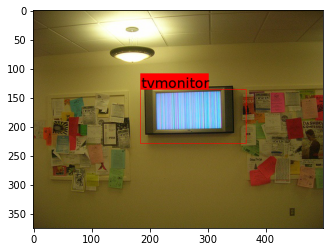

In [ ]:
train_rcnn(1000,images1,dataset)